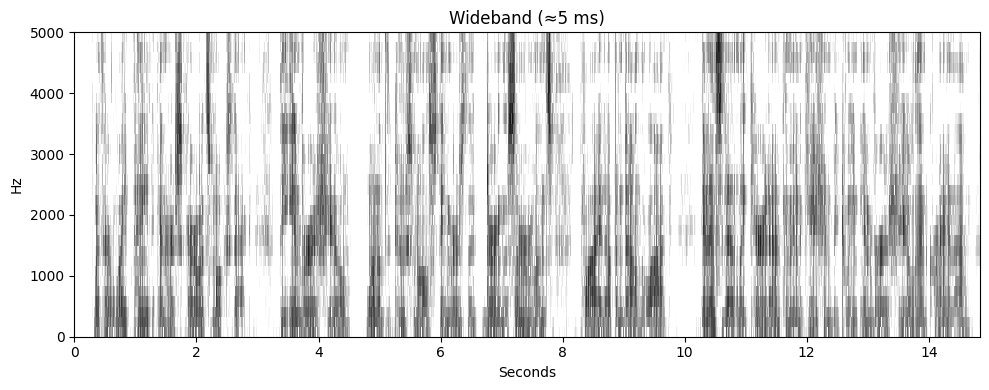

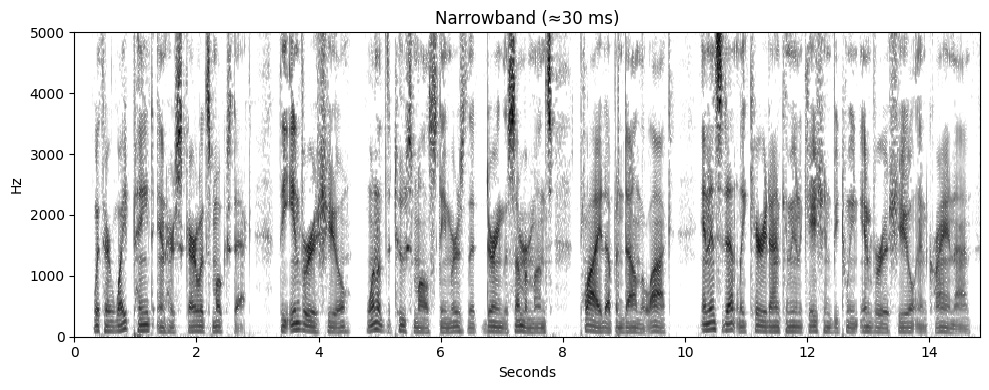

In [6]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import torch

def preemphasis_np(x, alpha=0.97):
    # simple + fast; good enough for display
    y = np.empty_like(x)
    y[0] = x[0]
    y[1:] = x[1:] - alpha * x[:-1]
    return y

def stft_db(x, sr, win_ms, hop_ms, n_fft=None, top_db=55.0, preemph=0.97):
    x = preemphasis_np(x, preemph)

    win_length = int(sr * win_ms / 1000.0)
    hop_length = int(sr * hop_ms / 1000.0)
    if n_fft is None:
        n_fft = 1 << (win_length - 1).bit_length()

    # Gaussian-ish window feel: use a Hann but keep everything else “display-correct”.
    # (If you want true Gaussian in torch, we can swap it in—this already becomes readable.)
    S = np.abs(librosa.stft(
        x,
        n_fft=n_fft,
        hop_length=hop_length,
        win_length=win_length,
        window="hann",
        center=True
    ))**2

    S_db = librosa.power_to_db(S, ref=np.max, top_db=top_db)
    freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    times = librosa.frames_to_time(np.arange(S_db.shape[1]), sr=sr, hop_length=hop_length)
    return S_db, freqs, times

def plot_spec(S_db, freqs, times, fmax=5000, title=""):
    keep = freqs <= fmax
    S_db = S_db[keep]
    freqs = freqs[keep]

    plt.figure(figsize=(10, 4))
    plt.imshow(
        S_db,
        origin="lower",
        aspect="auto",
        interpolation="none",
        extent=[times[0], times[-1], freqs[0], freqs[-1]],
        cmap="gray_r"  # <-- this inversion is often the “Praat readability” difference
    )
    plt.ylim(0, fmax)
    plt.xlabel("Seconds")
    plt.ylabel("Hz")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# --- Load speech ---
x, sr = librosa.load(librosa.ex("libri1"), sr=None, mono=True)

# Wideband (segmentation/formants/bursts)
S_db_w, freqs_w, times_w = stft_db(x, sr, win_ms=5.0, hop_ms=1.0, top_db=55.0)
plot_spec(S_db_w, freqs_w, times_w, fmax=5000, title="Wideband (≈5 ms)")

# Narrowband (harmonics/voicing)
S_db_n, freqs_n, times_n = stft_db(x, sr, win_ms=30.0, hop_ms=5.0, top_db=55.0)
plot_spec(S_db_n, freqs_n, times_n, fmax=5000, title="Narrowband (≈30 ms)")
